In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Upload Signal 1
from google.colab import files
print("\n Upload Signal 1 (Your voice saying 'hello'):")
uploaded_files_1 = files.upload()
signal1_filename = list(uploaded_files_1.keys())[0]



 Upload Signal 1 (Your voice saying 'hello'):


Saving Hello_Female.mp3 to Hello_Female.mp3


In [3]:
print("\n Upload Signal 2 (Friend's voice saying 'hello'):")
uploaded_files_2 = files.upload()
signal2_filename = list(uploaded_files_2.keys())[0]


 Upload Signal 2 (Friend's voice saying 'hello'):


Saving Hello_Male.mp3 to Hello_Male.mp3


In [4]:
# Load audio files using librosa (more efficient)
y1, sr1 = librosa.load(signal1_filename, sr=None)
y2, sr2 = librosa.load(signal2_filename, sr=None)

In [5]:
print(f"\nSignal 1 - Sample Rate: {sr1} Hz, Duration: {len(y1)/sr1:.3f} seconds")
print(f"Signal 2 - Sample Rate: {sr2} Hz, Duration: {len(y2)/sr2:.3f} seconds")


Signal 1 - Sample Rate: 48000 Hz, Duration: 0.816 seconds
Signal 2 - Sample Rate: 24000 Hz, Duration: 0.624 seconds


In [7]:
# Resample to same sampling rate if different
if sr1 != sr2:
    y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
    print(f"\n Resampled Signal 2 to {sr1} Hz for consistency")


 Resampled Signal 2 to 48000 Hz for consistency


In [8]:
sr = sr1  # Use Signal 1's sampling rate

In [ ]:
from IPython.display import Audio, display
import os
display(Audio(data=signal1_filename, rate=sr))

In [ ]:
display(Audio(data=signal2_filename, rate=sr))

In [9]:
# Extract MFCC features (more efficient than raw waveform for DTW)
# MFCCs reduce dimensionality significantly
n_mfcc = 13
mfcc1 = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=n_mfcc)
mfcc2 = librosa.feature.mfcc(y=y2, sr=sr, n_mfcc=n_mfcc)

print(f"\nMFCC Shape Signal 1: {mfcc1.shape}")
print(f"MFCC Shape Signal 2: {mfcc2.shape}")


MFCC Shape Signal 1: (13, 77)
MFCC Shape Signal 2: (13, 118)


In [10]:
def normalize_signal(signal_data):
    """Normalize signal to 0-1 range"""
    min_val = np.min(signal_data)
    max_val = np.max(signal_data)
    if max_val - min_val == 0:
        return signal_data
    return (signal_data - min_val) / (max_val - min_val)


In [11]:
# Normalize waveforms
y1_norm = normalize_signal(y1)
y2_norm = normalize_signal(y2)

In [12]:
# Normalize MFCC features
mfcc1_norm = normalize_signal(mfcc1)
mfcc2_norm = normalize_signal(mfcc2)

In [13]:
print("Waveforms normalized to [0, 1] range")
print("MFCC features normalized to [0, 1] range")

Waveforms normalized to [0, 1] range
MFCC features normalized to [0, 1] range


In [16]:
def euclidean_distance(x, y):
    """Compute Euclidean distance between two points"""
    return np.sqrt(np.sum((x - y) ** 2))

In [14]:
def dtw_distance(signal1, signal2, use_mfcc=True):
    """
    Compute DTW distance and cost matrix with efficient memory usage

    Parameters:
    - signal1: First time series (features x time)
    - signal2: Second time series (features x time)
    - use_mfcc: If True, signals are in (n_features, n_frames) format

    Returns:
    - dtw_dist: DTW distance (scalar)
    - cost_matrix: Accumulated cost matrix
    - path: Alignment path
    """

    if use_mfcc:
        # For MFCC: shape is (n_features, n_frames)
        n1, m1 = signal1.shape[1], signal1.shape[0]
        n2, m2 = signal2.shape[1], signal2.shape[0]
        n_features = signal1.shape[0]
    else:
        n1 = len(signal1)
        n2 = len(signal2)

    # Initialize cost matrix with infinity
    cost_matrix = np.full((n1, n2), np.inf)
    cost_matrix[0, 0] = 0

    # Fill cost matrix efficiently
    for i in range(n1):
        for j in range(n2):
            if np.isinf(cost_matrix[i, j]):
                if use_mfcc:
                    # Compute distance between MFCC frames
                    d = euclidean_distance(signal1[:, i], signal2[:, j])
                else:
                    d = abs(signal1[i] - signal2[j])

                cost_matrix[i, j] = d + min(
                    cost_matrix[i-1, j],      # insertion
                    cost_matrix[i, j-1],      # deletion
                    cost_matrix[i-1, j-1]     # match
                )

    # Backtrack to find alignment path
    path = [(n1-1, n2-1)]
    i, j = n1 - 1, n2 - 1

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            min_idx = np.argmin([
                cost_matrix[i-1, j-1],
                cost_matrix[i-1, j],
                cost_matrix[i, j-1]
            ])
            if min_idx == 0:
                i -= 1
                j -= 1
            elif min_idx == 1:
                i -= 1
            else:
                j -= 1

        path.append((i, j))

    path.reverse()
    dtw_dist = cost_matrix[n1-1, n2-1]

    return dtw_dist, cost_matrix, path

In [17]:
dtw_dist, cost_matrix, alignment_path = dtw_distance(mfcc1_norm, mfcc2_norm, use_mfcc=True)


In [18]:
print(f"DTW Distance: {dtw_dist:.4f}")
print(f"Alignment path length: {len(alignment_path)}")

DTW Distance: 42.9708
Alignment path length: 118


In [19]:
# Normalize DTW distance by path length for fair comparison
normalized_dtw = dtw_dist / len(alignment_path)
print(f" Normalized DTW Distance: {normalized_dtw:.4f}")

 Normalized DTW Distance: 0.3642


In [20]:
similarity_score = 1 / (1 + normalized_dtw)  # Convert distance to similarity
print(f" Similarity Score (0-1): {similarity_score:.4f}")


 Similarity Score (0-1): 0.7331


In [21]:
if similarity_score > 0.8:
    interpretation = " VERY SIMILAR - The signals match very well!"
elif similarity_score > 0.6:
    interpretation = "SIMILAR - The signals match reasonably well"
elif similarity_score > 0.4:
    interpretation = "MODERATELY SIMILAR - The signals have some differences"
else:
    interpretation = "DISSIMILAR - The signals are quite different"

print(f"{interpretation}")

SIMILAR - The signals match reasonably well


In [22]:
print(f"   - DTW finds the optimal alignment between signals of different lengths")
print(f"   - Lower DTW distance indicates higher similarity")
print(f"   - Our distance of {normalized_dtw:.4f} suggests {'good' if normalized_dtw < 1 else 'moderate'} matching")

   - DTW finds the optimal alignment between signals of different lengths
   - Lower DTW distance indicates higher similarity
   - Our distance of 0.3642 suggests good matching


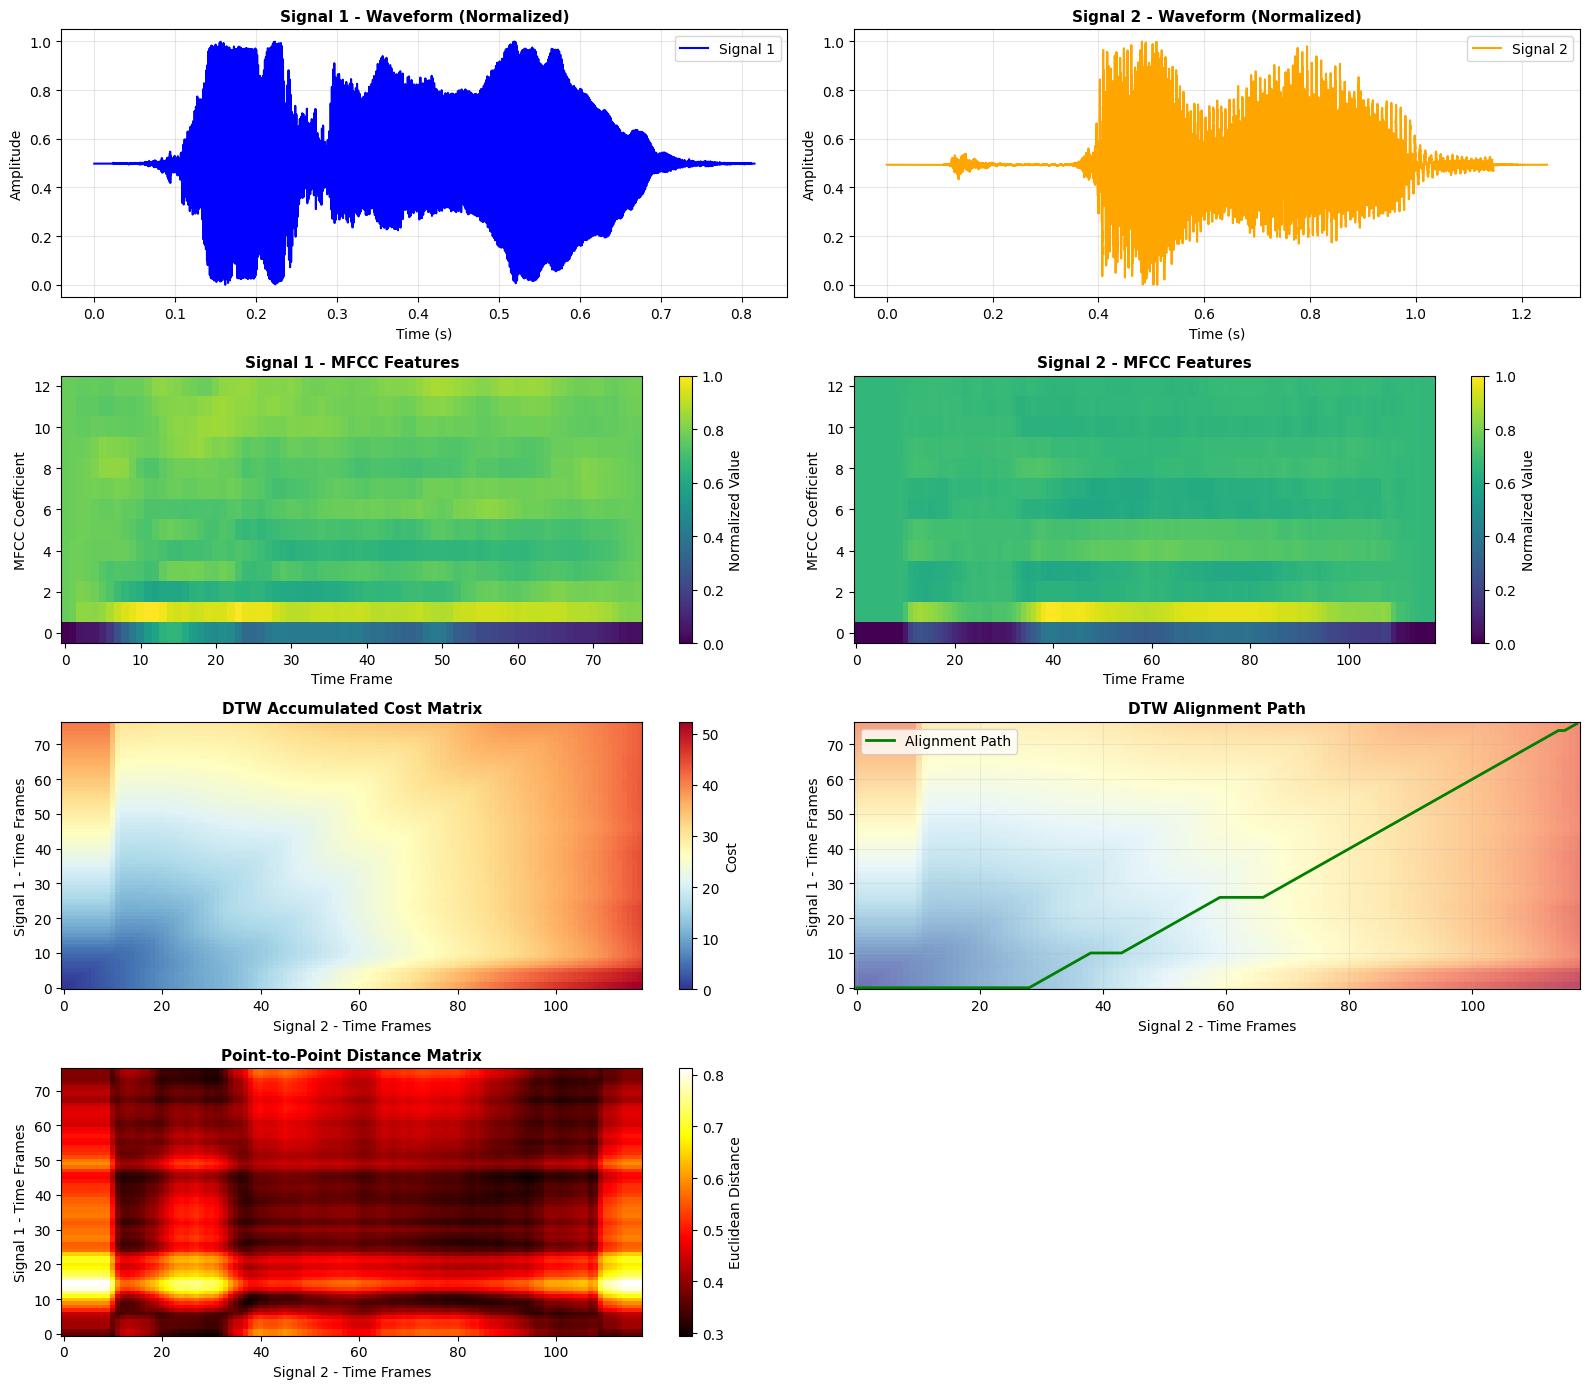

In [23]:
fig = plt.figure(figsize=(16, 14))

# 1. Waveforms
ax1 = plt.subplot(4, 2, 1)
time1 = np.linspace(0, len(y1) / sr, len(y1))
ax1.plot(time1, y1_norm, label='Signal 1', linewidth=1.5, color='blue')
ax1.set_title('Signal 1 - Waveform (Normalized)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2 = plt.subplot(4, 2, 2)
time2 = np.linspace(0, len(y2) / sr, len(y2))
ax2.plot(time2, y2_norm, label='Signal 2', linewidth=1.5, color='orange')
ax2.set_title('Signal 2 - Waveform (Normalized)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 2. MFCC Spectrograms
ax3 = plt.subplot(4, 2, 3)
img1 = ax3.imshow(mfcc1_norm, aspect='auto', origin='lower', cmap='viridis')
ax3.set_title('Signal 1 - MFCC Features', fontsize=11, fontweight='bold')
ax3.set_xlabel('Time Frame')
ax3.set_ylabel('MFCC Coefficient')
plt.colorbar(img1, ax=ax3, label='Normalized Value')

ax4 = plt.subplot(4, 2, 4)
img2 = ax4.imshow(mfcc2_norm, aspect='auto', origin='lower', cmap='viridis')
ax4.set_title('Signal 2 - MFCC Features', fontsize=11, fontweight='bold')
ax4.set_xlabel('Time Frame')
ax4.set_ylabel('MFCC Coefficient')
plt.colorbar(img2, ax=ax4, label='Normalized Value')

# 3. DTW Cost Matrix
ax5 = plt.subplot(4, 2, 5)
im = ax5.imshow(cost_matrix, aspect='auto', origin='lower', cmap='RdYlBu_r')
ax5.set_title('DTW Accumulated Cost Matrix', fontsize=11, fontweight='bold')
ax5.set_xlabel('Signal 2 - Time Frames')
ax5.set_ylabel('Signal 1 - Time Frames')
plt.colorbar(im, ax=ax5, label='Cost')

# 4. Alignment Path on Cost Matrix
ax6 = plt.subplot(4, 2, 6)
ax6.imshow(cost_matrix, aspect='auto', origin='lower', cmap='RdYlBu_r', alpha=0.7)
path_array = np.array(alignment_path)
ax6.plot(path_array[:, 1], path_array[:, 0], 'g-', linewidth=2, label='Alignment Path')
ax6.set_title('DTW Alignment Path', fontsize=11, fontweight='bold')
ax6.set_xlabel('Signal 2 - Time Frames')
ax6.set_ylabel('Signal 1 - Time Frames')
ax6.legend()
ax6.grid(True, alpha=0.2)

# 5. Point-to-Point Distance Matrix
ax7 = plt.subplot(4, 2, 7)
# Compute pairwise distance matrix between all time frames
distance_matrix = np.zeros((mfcc1_norm.shape[1], mfcc2_norm.shape[1]))
for i in range(mfcc1_norm.shape[1]):
    for j in range(mfcc2_norm.shape[1]):
        distance_matrix[i, j] = euclidean_distance(mfcc1_norm[:, i], mfcc2_norm[:, j])

im_dist = ax7.imshow(distance_matrix, aspect='auto', origin='lower', cmap='hot')
ax7.set_title('Point-to-Point Distance Matrix', fontsize=11, fontweight='bold')
ax7.set_xlabel('Signal 2 - Time Frames')
ax7.set_ylabel('Signal 1 - Time Frames')
plt.colorbar(im_dist, ax=ax7, label='Euclidean Distance')
plt.tight_layout()
plt.savefig('dtw_analysis.png', dpi=100, bbox_inches='tight')
plt.show()